In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import xarray as xr
from tqdm import tqdm
from scipy.constants import c
from interleaver_3_stages import interleaver_3_stage_calc, calculate_spectrum_bandwidth

In [2]:
gf45clo_pdk_sin_neff_ng_variability = pd.read_csv("gf45clo_pdk_sin_neff_ng_variability.csv")
gf45clo_sin_neff_ng_variability = gf45clo_pdk_sin_neff_ng_variability[
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_width']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_height']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_sidewall_angle']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['wg_width (nm)']<1.5)
]

In [3]:
XPS_first_stage_loss_dB   = 0.07
XPS_second_stage_loss_dB  = 0.07
XPS_third_stage_loss_dB   = 0.07
SiN_propagation_loss_dB_m = 40
SiN_directional_coupler_loss_dB = 0.01

SiN_group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0'].values)
SiN_effective_index = np.median(gf45clo_sin_neff_ng_variability['neff_freq0'].values)
center_wavelength = 1310e-9
freq = c/(center_wavelength)
FSR_wavelength = 1600e9 * (center_wavelength)**2/(c)
channel_spacing = FSR_wavelength/8
channel1_wavelength = center_wavelength - 3.5*channel_spacing
channel2_wavelength = center_wavelength - 2.5*channel_spacing
channel3_wavelength = center_wavelength - 1.5*channel_spacing
channel4_wavelength = center_wavelength - 0.5*channel_spacing
channel5_wavelength = center_wavelength + 0.5*channel_spacing
channel6_wavelength = center_wavelength + 1.5*channel_spacing
channel7_wavelength = center_wavelength + 2.5*channel_spacing
channel8_wavelength = center_wavelength + 3.5*channel_spacing
channel_wavelength_array = [
    channel1_wavelength,
    channel2_wavelength,
    channel3_wavelength,
    channel4_wavelength,
    channel5_wavelength,
    channel6_wavelength,
    channel7_wavelength,
    channel8_wavelength,
]
dL_1600Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength)
dL_800Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength/2)
dL_400Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength/4)

optimization_wavelength_sweep = np.linspace(1295e-9,1325e-9,num=4000)
cost_function_plot_alpha = 0.3
bounds_epsilon = 5e-3

dL for 400Ghz FSR:  0.00038810533884040785
   #    DCSplit0    DCSplit1    DCSplit2    phi1        phi2      phi3       Cost
   0    0.500000    0.787000    0.822000    2.911943  -3.068172 -0.106517   3051.513256
  10    0.503333    0.783667    0.825333    2.782523  -3.170444 -0.105926   2851.031814
  20    0.503457    0.786774    0.827000    2.133827  -3.569433 -0.105918   2101.603909
  30    0.504272    0.782000    0.827000    2.036655  -3.998125 -0.102474   1745.195439
  40    0.502735    0.782000    0.825576    1.636707  -4.812378 -0.104077   1644.936359
  50    0.504153    0.782311    0.825064    1.745719  -4.439676 -0.099567   1592.805534
  60    0.503928    0.782483    0.825326    1.868350  -4.480657 -0.096553   1581.438676
  70    0.503377    0.782863    0.824855    1.771304  -4.571757 -0.094875   1580.526165
  80    0.503411    0.782825    0.824930    1.780534  -4.541175 -0.095193   1579.010502
  90    0.503324    0.782881    0.825193    1.818890  -4.555744 -0.094304   1578.38

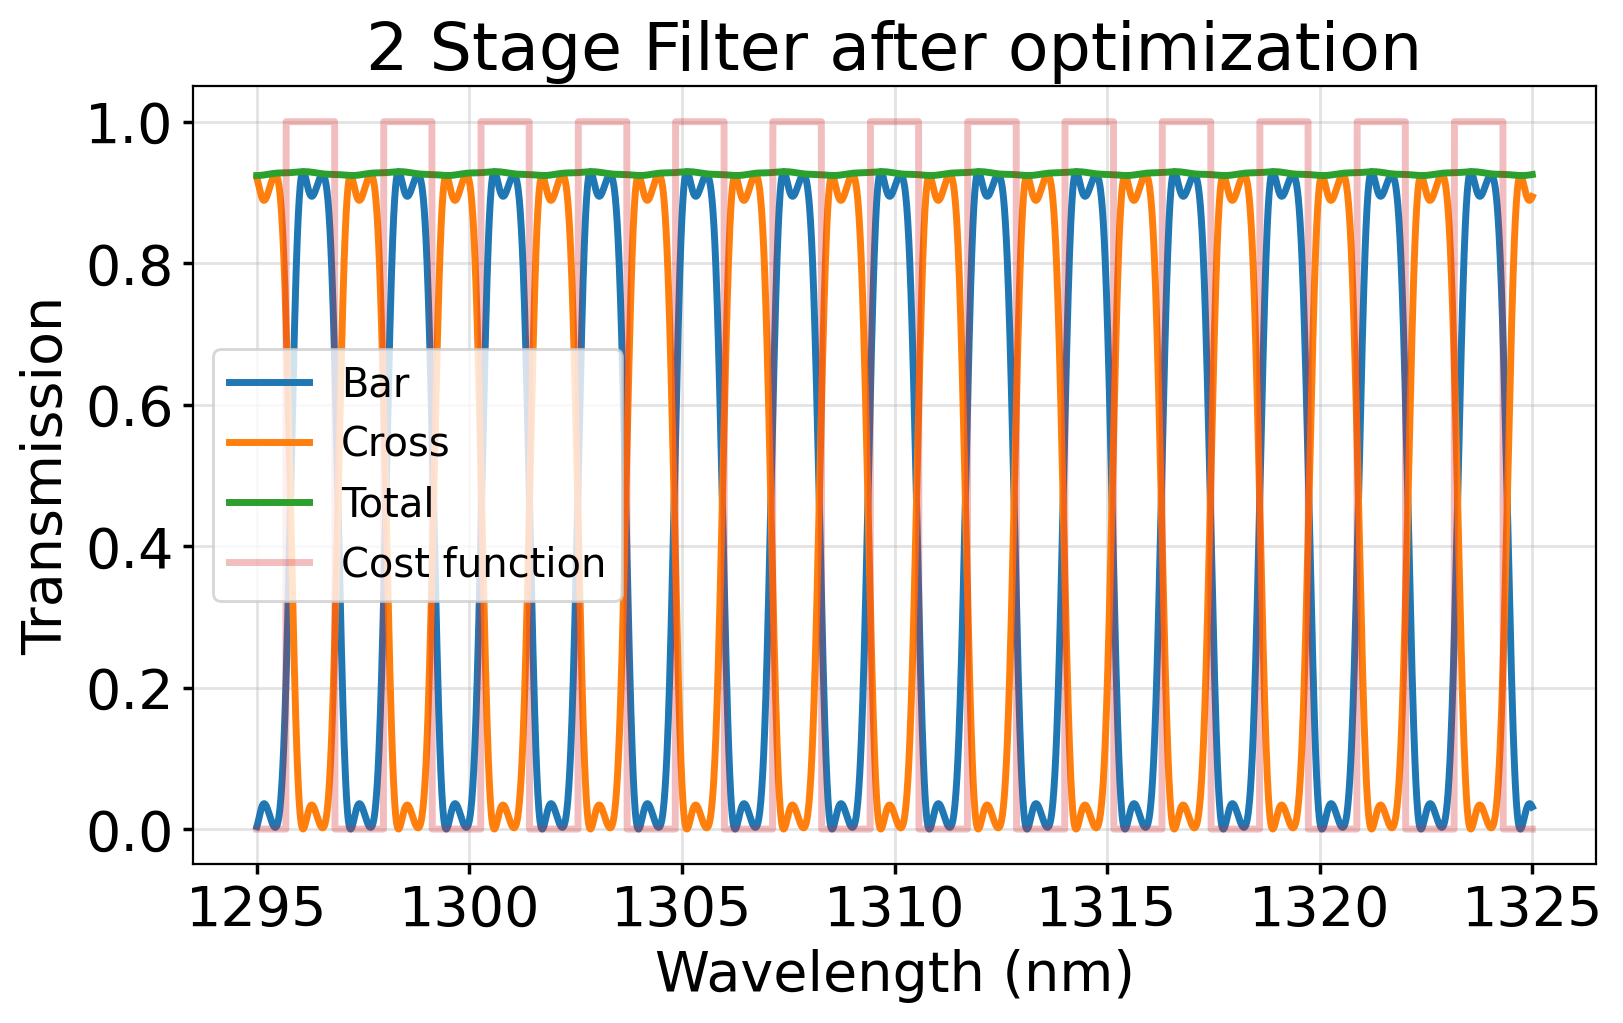

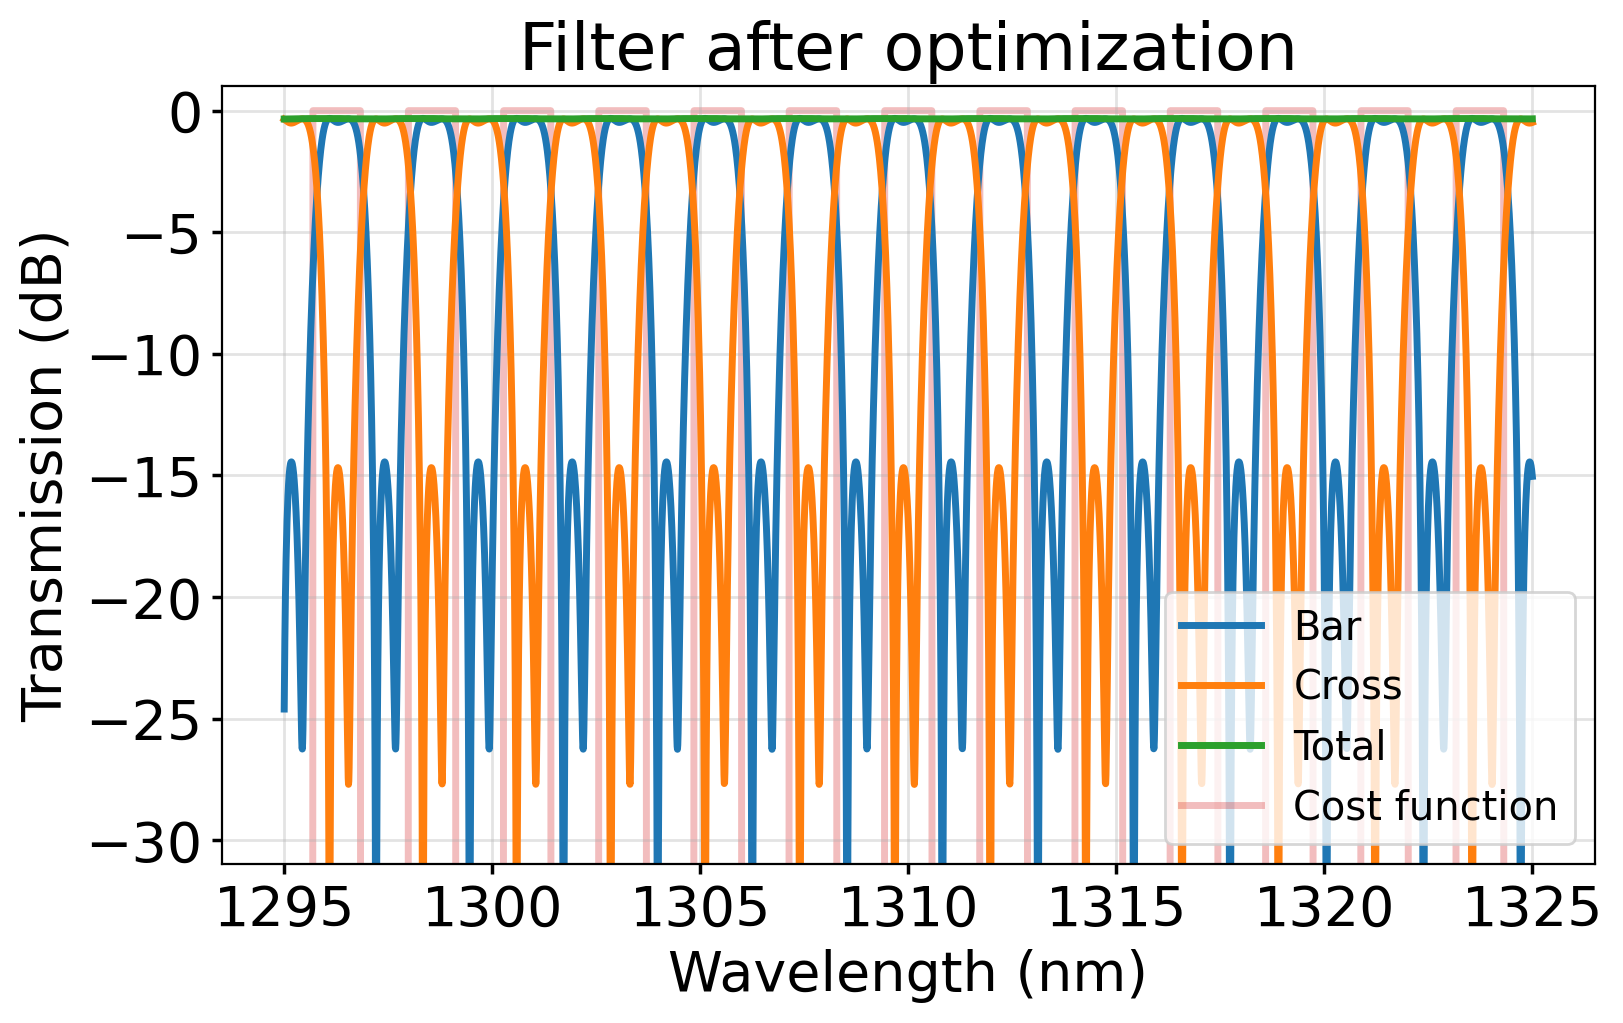

In [4]:
# Create compound effect of the three filter stages on top of each other
print("dL for 400Ghz FSR: ", dL_400Ghz_FSR)
um = 1e-6

interleaver_400Ghz_FSR = interleaver_3_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dL3 = 2*dL_400Ghz_FSR,
    dc0 = 0.5,
    dc1 = 0.787,
    dc2 = 0.822,
    effective_index = np.median(gf45clo_sin_neff_ng_variability['neff_freq0'].values),
    group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0'].values),
    
)
interleaver_400Ghz_FSR.channel_spacing = FSR_wavelength/8

interleaver_400Ghz_result = interleaver_400Ghz_FSR.minimize_cost_function(random_dc=False,random_phase=True,printy=True)

wav,bar_port_amp,cross_port_amp = interleaver_400Ghz_FSR.calculate_spectrum(*interleaver_400Ghz_result.x)

print("First stage insertion loss (dB): ", np.max(10*np.log10(bar_port_amp)))

interleaver_400Ghz_FSR.plot_spectrum(interleaver_400Ghz_result)

In [5]:
num_sweep = len(gf45clo_sin_neff_ng_variability['neff_freq0'].values)

channel_offset_list = [0e9, 10e9, 20e9, 30e9, 40e9, 50e9, 60e9, 70e9]

random_variable_sigma = [0.02, 0.05, 0.1]
dc_variability = ["common", "differential"]
simulation = ["montecarlo","dc_variability"]

rand_dc1 = {}
rand_dc2 = {}
rand_dc3 = {}

for sigma in random_variable_sigma:
    rand_dc1[sigma] = 1+np.random.normal(0, sigma, num_sweep)
    rand_dc2[sigma] = 1+np.random.normal(0, sigma, num_sweep)
    rand_dc3[sigma] = 1+np.random.normal(0, sigma, num_sweep)

In [6]:
um = 1e-6

interleaver_dataset = {}

idd_interleaver = 1
for sim_mode in simulation:
    for dc_mode in dc_variability:
        for sigma in random_variable_sigma:
            for idd_rand in tqdm(range(num_sweep)):
                interleaver_dc1 = rand_dc1[sigma][idd_rand] * 0.5
                interleaver_dc2 = rand_dc2[sigma][idd_rand] * 0.787
                interleaver_dc3 = rand_dc3[sigma][idd_rand] * 0.822
                if dc_mode == "common":
                    interleaver_dc2 = rand_dc1[sigma][idd_rand] * 0.787 
                    interleaver_dc3 = rand_dc1[sigma][idd_rand] * 0.822

                interleaver_dc1 = np.clip(interleaver_dc1, a_min=0, a_max=1)
                interleaver_dc2 = np.clip(interleaver_dc2, a_min=0, a_max=1)
                interleaver_dc3 = np.clip(interleaver_dc3, a_min=0, a_max=1)
                if sim_mode == "montecarlo":
                    effective_index = gf45clo_sin_neff_ng_variability['neff_freq0'].values[idd_rand]
                    group_index = gf45clo_sin_neff_ng_variability['ng_freq0'].values[idd_rand]
                else:
                    effective_index = np.median(gf45clo_sin_neff_ng_variability['neff_freq0'].values)
                    group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0'].values)

                variation_interleaver = interleaver_3_stage_calc(
                    L=350*um,
                    dL1 = dL_400Ghz_FSR,
                    dL2 = 2*dL_400Ghz_FSR,
                    dL3 = 2*dL_400Ghz_FSR,
                    dc0 = interleaver_dc1,
                    dc1 = interleaver_dc2,
                    dc2 = interleaver_dc3,
                    effective_index = effective_index,
                    group_index = group_index,
                )
                variation_interleaver.channel_spacing = FSR_wavelength/8

                variation_interleaver.phase_shift_1_top = interleaver_400Ghz_result.x[3]
                variation_interleaver.phase_shift_2_top = interleaver_400Ghz_result.x[4]

                new_dev_params = [
                    interleaver_dc1,
                    interleaver_dc2,
                    interleaver_dc3,
                    interleaver_400Ghz_FSR.phase_shift_1_top,
                    interleaver_400Ghz_FSR.phase_shift_2_top,
                    interleaver_400Ghz_FSR.phase_shift_3_top,
                ]

                wav, bar_port_amp, cross_port_amp = variation_interleaver.calculate_spectrum(*new_dev_params)
                bar_port_fom = calculate_spectrum_bandwidth(wav, bar_port_amp, IL_channel_offset = channel_offset_list)
                cross_port_fom = calculate_spectrum_bandwidth(wav, bar_port_amp, IL_channel_offset = channel_offset_list)

                interleaver_dataset[idd_interleaver] = {
                    "wg_width":gf45clo_sin_neff_ng_variability['wg_width (nm)'].values[idd_rand],
                    "wg_height":gf45clo_sin_neff_ng_variability['wg_height (nm)'].values[idd_rand],
                    "wg_sidewall_angle":gf45clo_sin_neff_ng_variability['wg_sidewall_angle (rad)'].values[idd_rand],
                    "neff":effective_index,
                    "ng":group_index,
                    "simulation_mode": sim_mode,
                    "dc_variability_mode":dc_mode,
                    "sigma":sigma,
                    "interleaver_dc1": interleaver_dc1,
                    "interleaver_dc2": interleaver_dc2,
                    "interleaver_dc3": interleaver_dc3,
                    "wav": wav,
                    "bar_port_amp": bar_port_amp,
                    "cross_port_amp": cross_port_amp,
                    "bar_port_fom": bar_port_fom,
                    "cross_port_fom": cross_port_fom
                }

                idd_interleaver += 1

100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [54:45<00:00,  2.19s/it]


In [7]:
gf45clo_pdk_sin_neff_ng_variability = pd.read_csv("gf45clo_pdk_sin_neff_ng_variability.csv")
gf45clo_sin_neff_ng_variability = gf45clo_pdk_sin_neff_ng_variability[
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_width']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_height']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['rand_wg_sidewall_angle']==True) & 
    (gf45clo_pdk_sin_neff_ng_variability['wg_width (nm)']>1.5)
]

In [8]:
XPS_first_stage_loss_dB   = 0.07
XPS_second_stage_loss_dB  = 0.07
XPS_third_stage_loss_dB   = 0.07
SiN_propagation_loss_dB_m = 40
SiN_directional_coupler_loss_dB = 0.01

SiN_group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0'].values)
SiN_effective_index = np.median(gf45clo_sin_neff_ng_variability['neff_freq0'].values)
center_wavelength = 1310e-9
freq = c/(center_wavelength)
FSR_wavelength = 1600e9 * (center_wavelength)**2/(c)
channel_spacing = FSR_wavelength/8
channel1_wavelength = center_wavelength - 3.5*channel_spacing
channel2_wavelength = center_wavelength - 2.5*channel_spacing
channel3_wavelength = center_wavelength - 1.5*channel_spacing
channel4_wavelength = center_wavelength - 0.5*channel_spacing
channel5_wavelength = center_wavelength + 0.5*channel_spacing
channel6_wavelength = center_wavelength + 1.5*channel_spacing
channel7_wavelength = center_wavelength + 2.5*channel_spacing
channel8_wavelength = center_wavelength + 3.5*channel_spacing
channel_wavelength_array = [
    channel1_wavelength,
    channel2_wavelength,
    channel3_wavelength,
    channel4_wavelength,
    channel5_wavelength,
    channel6_wavelength,
    channel7_wavelength,
    channel8_wavelength,
]
dL_1600Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength)
dL_800Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength/2)
dL_400Ghz_FSR = (center_wavelength)**2/(SiN_group_index * FSR_wavelength/4)

optimization_wavelength_sweep = np.linspace(1295e-9,1325e-9,num=4000)
cost_function_plot_alpha = 0.3
bounds_epsilon = 5e-3

dL for 400Ghz FSR:  0.00038527681460434805
   #    DCSplit0    DCSplit1    DCSplit2    phi1        phi2      phi3       Cost
   0    0.500000    0.787000    0.822000    2.666062  -2.320095 -1.853690   5209.242291
  10    0.503333    0.790333    0.818667    2.651250  -2.216979 -1.915480   5039.972600
  20    0.505000    0.787370    0.826306    2.694862  -1.437886 -2.093983   4060.614030
  30    0.504191    0.788541    0.826079    2.546368   0.184047 -2.380611   3888.737035
  40    0.500217    0.792000    0.827000    3.330636   0.598236 -1.673121   2195.280507
  50    0.500341    0.790564    0.825660    3.424727  -0.270952 -1.370611   3184.587422
  60    0.497487    0.789265    0.824635    3.953981   1.666404 -1.266174   1867.305302
  70    0.496164    0.788369    0.824133    4.184668   1.753199 -1.184047   1819.833248
  80    0.497261    0.784940    0.824694    4.036077   1.653060 -1.481503   1692.123515
  90    0.497277    0.782000    0.824054    4.198481   1.549597 -1.790523   1418.69

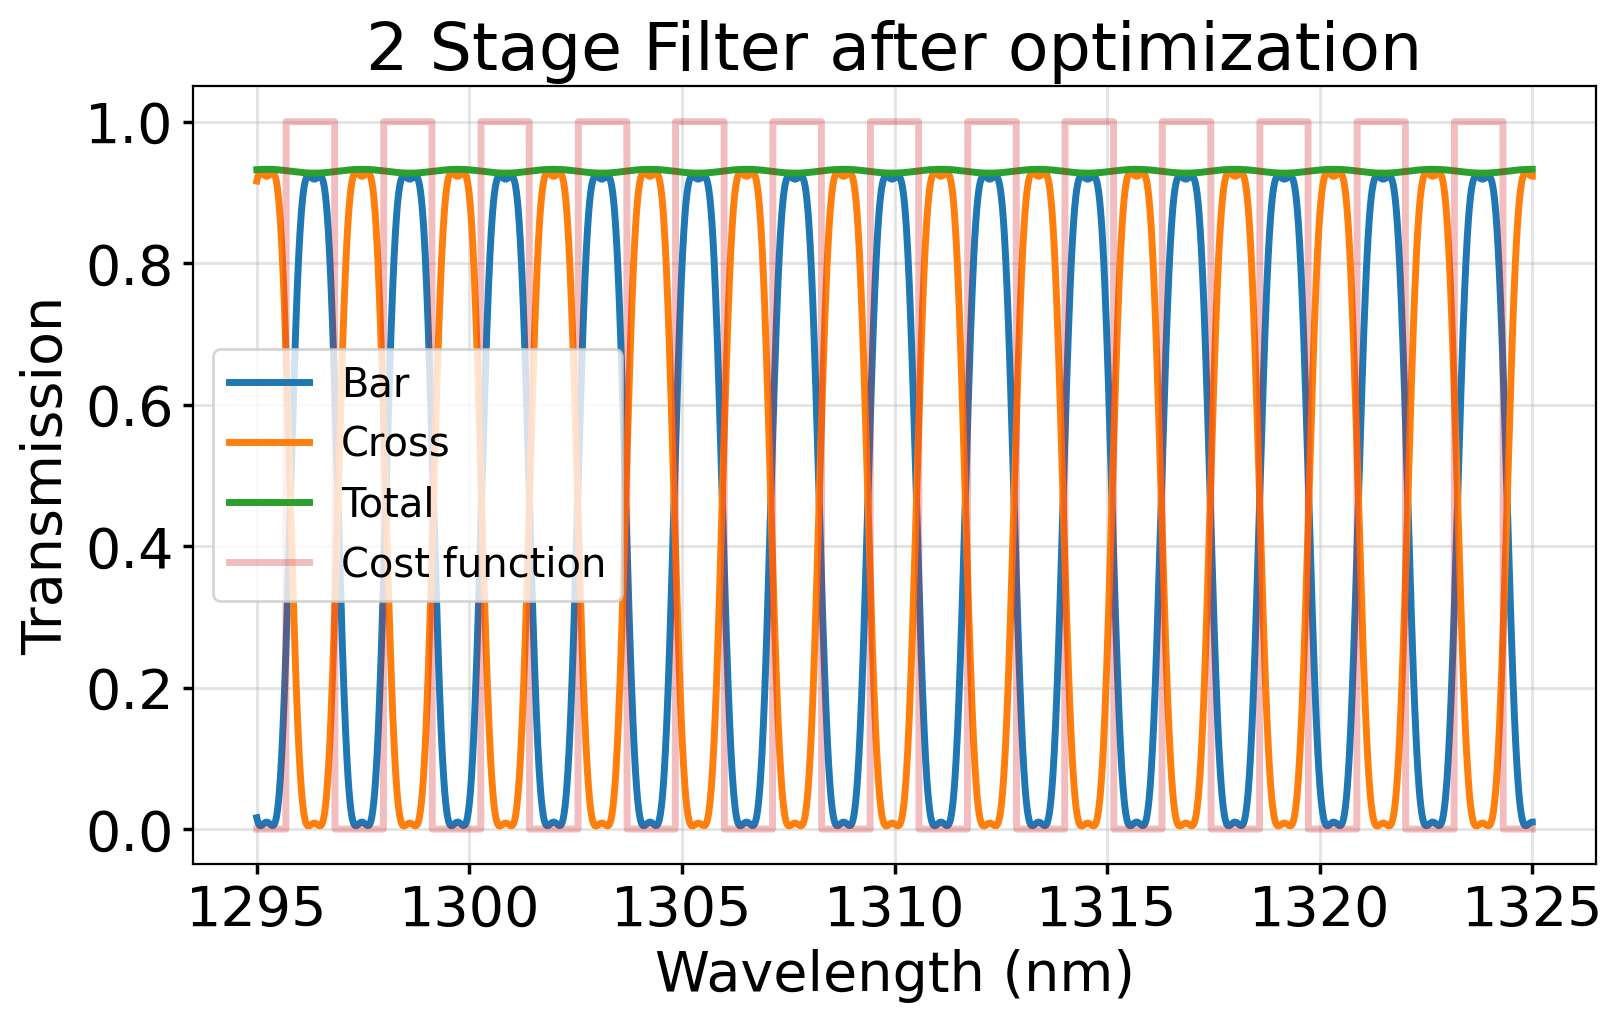

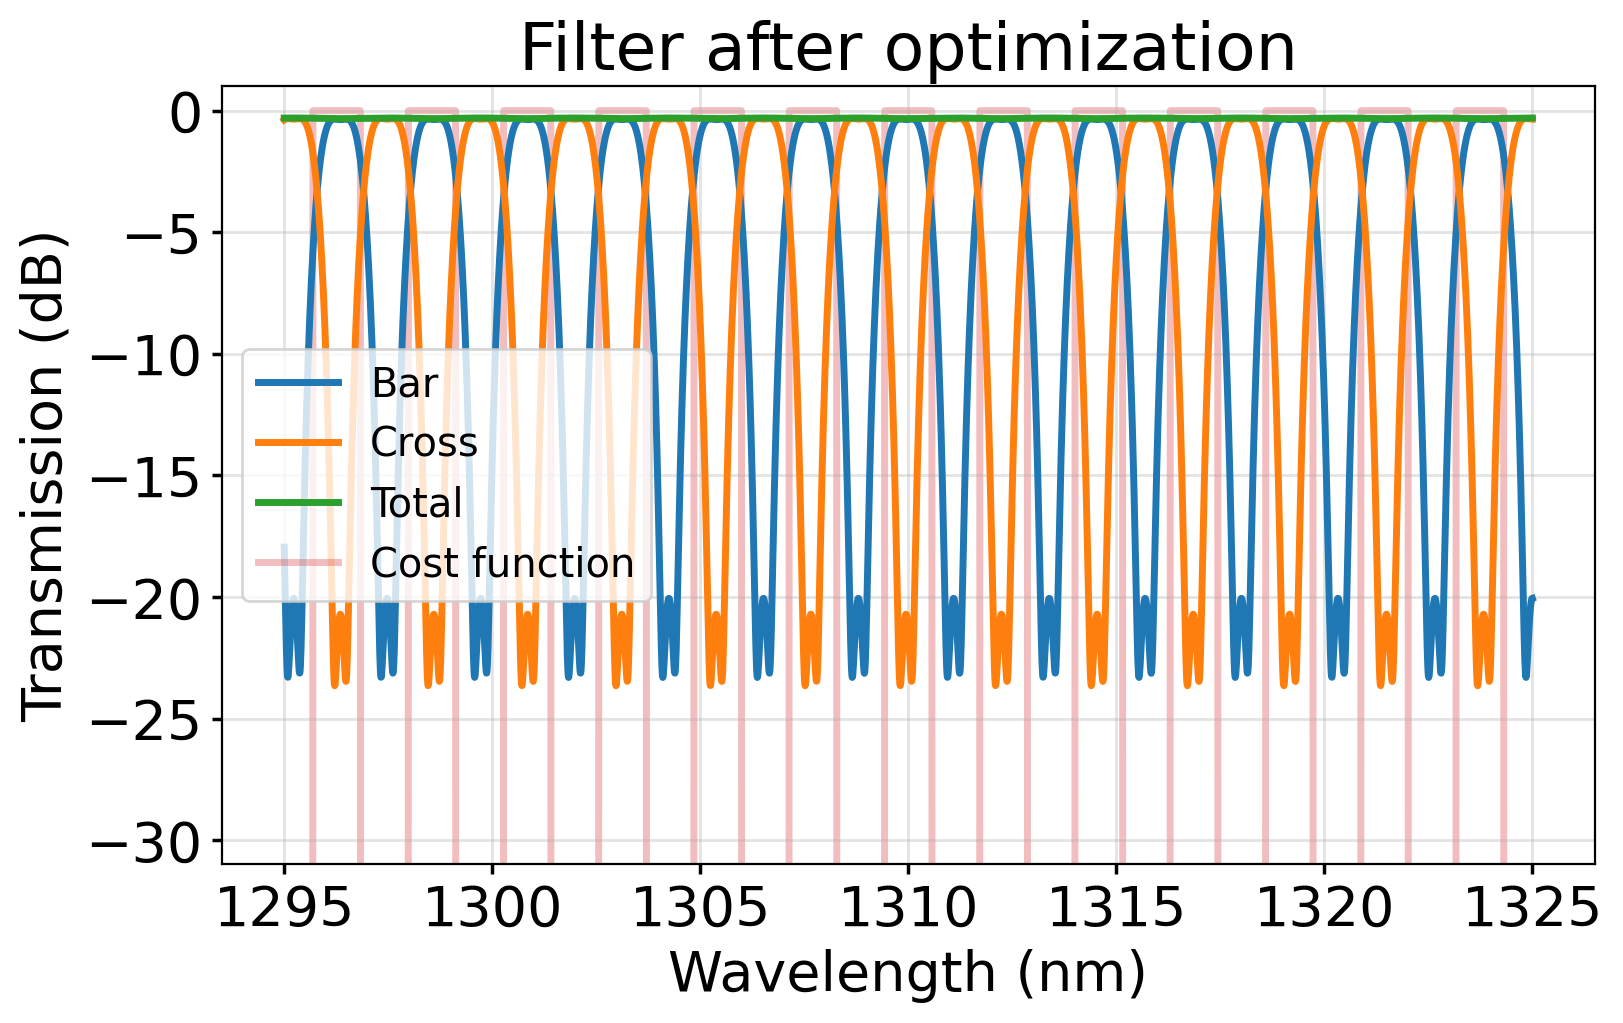

In [9]:
# Create compound effect of the three filter stages on top of each other
print("dL for 400Ghz FSR: ", dL_400Ghz_FSR)
um = 1e-6

interleaver_400Ghz_FSR = interleaver_3_stage_calc(
    L = 350*um,
    dL1 = dL_400Ghz_FSR,
    dL2 = 2*dL_400Ghz_FSR,
    dc0 = 0.5,
    dc1 = 0.787,
    dc2 = 0.822,
    effective_index = np.median(gf45clo_sin_neff_ng_variability['neff_freq0'].values),
    group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0'].values),
    
)
interleaver_400Ghz_FSR.channel_spacing = FSR_wavelength/8

interleaver_400Ghz_result = interleaver_400Ghz_FSR.minimize_cost_function(random_dc=False,random_phase=True,printy=True)

wav,bar_port_amp,cross_port_amp = interleaver_400Ghz_FSR.calculate_spectrum(*interleaver_400Ghz_result.x)

print("First stage insertion loss (dB): ", np.max(10*np.log10(bar_port_amp)))

interleaver_400Ghz_FSR.plot_spectrum(interleaver_400Ghz_result)

In [10]:
um = 1e-6
for sim_mode in simulation:
    for dc_mode in dc_variability:
        for sigma in random_variable_sigma:
            for idd_rand in tqdm(range(num_sweep)):
                interleaver_dc1 = rand_dc1[sigma][idd_rand] * 0.5
                interleaver_dc2 = rand_dc2[sigma][idd_rand] * 0.787
                interleaver_dc3 = rand_dc3[sigma][idd_rand] * 0.822
                if dc_mode == "common":
                    interleaver_dc2 = rand_dc1[sigma][idd_rand] * 0.787 
                    interleaver_dc3 = rand_dc1[sigma][idd_rand] * 0.822

                interleaver_dc1 = np.clip(interleaver_dc1, a_min=0, a_max=1)
                interleaver_dc2 = np.clip(interleaver_dc2, a_min=0, a_max=1)
                interleaver_dc3 = np.clip(interleaver_dc3, a_min=0, a_max=1)
                if sim_mode == "montecarlo":
                    effective_index = gf45clo_sin_neff_ng_variability['neff_freq0'].values[idd_rand]
                    group_index = gf45clo_sin_neff_ng_variability['ng_freq0'].values[idd_rand]
                else:
                    effective_index = np.median(gf45clo_sin_neff_ng_variability['neff_freq0'].values)
                    group_index = np.median(gf45clo_sin_neff_ng_variability['ng_freq0'].values)

                variation_interleaver = interleaver_3_stage_calc(
                    L=350*um,
                    dL1 = dL_400Ghz_FSR,
                    dL2 = 2*dL_400Ghz_FSR,
                    dL3 = 2*dL_400Ghz_FSR,
                    dc0 = interleaver_dc1,
                    dc1 = interleaver_dc2,
                    dc2 = interleaver_dc3,
                    effective_index = effective_index,
                    group_index = group_index,
                )
                variation_interleaver.channel_spacing = FSR_wavelength/8

                variation_interleaver.phase_shift_1_top = interleaver_400Ghz_result.x[3]
                variation_interleaver.phase_shift_2_top = interleaver_400Ghz_result.x[4]

                new_dev_params = [
                    interleaver_dc1,
                    interleaver_dc2,
                    interleaver_dc3,
                    interleaver_400Ghz_FSR.phase_shift_1_top,
                    interleaver_400Ghz_FSR.phase_shift_2_top,
                    interleaver_400Ghz_FSR.phase_shift_3_top,
                ]

                wav, bar_port_amp, cross_port_amp = variation_interleaver.calculate_spectrum(*new_dev_params)
                bar_port_fom = calculate_spectrum_bandwidth(wav, bar_port_amp, IL_channel_offset = channel_offset_list)
                cross_port_fom = calculate_spectrum_bandwidth(wav, bar_port_amp, IL_channel_offset = channel_offset_list)

                interleaver_dataset[idd_interleaver] = {
                    "wg_width":gf45clo_sin_neff_ng_variability['wg_width (nm)'].values[idd_rand],
                    "wg_height":gf45clo_sin_neff_ng_variability['wg_height (nm)'].values[idd_rand],
                    "wg_sidewall_angle":gf45clo_sin_neff_ng_variability['wg_sidewall_angle (rad)'].values[idd_rand],
                    "neff":effective_index,
                    "ng":group_index,
                    "simulation_mode": sim_mode,
                    "dc_variability_mode":dc_mode,
                    "sigma":sigma,
                    "interleaver_dc1": interleaver_dc1,
                    "interleaver_dc2": interleaver_dc2,
                    "interleaver_dc3": interleaver_dc3,
                    "wav": wav,
                    "bar_port_amp": bar_port_amp,
                    "cross_port_amp": cross_port_amp,
                    "bar_port_fom": bar_port_fom,
                    "cross_port_fom": cross_port_fom
                }

                idd_interleaver += 1

100%|████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [41:57<00:00,  1.68s/it]


In [11]:
bar_port_amp_xr = np.zeros((len(simulation), len(dc_variability), len(random_variable_sigma), num_sweep, 2, len(wav)))
cross_port_amp_xr = np.zeros((len(simulation), len(dc_variability), len(random_variable_sigma), num_sweep, 2, len(wav)))
bar_port_fom_xr = np.zeros((len(simulation), len(dc_variability), len(random_variable_sigma), num_sweep, 2, 7, 8))
cross_port_fom_xr = np.zeros((len(simulation), len(dc_variability), len(random_variable_sigma), num_sweep, 2, 7, 8))

wg_1_params_xr = np.zeros((5,num_sweep))
wg_2_params_xr = np.zeros((5,num_sweep))
dc_params_xr = np.zeros((len(random_variable_sigma), 3, num_sweep))

wg_params = ["wg_width","wg_height","wg_sidewall_angle","neff","ng"]
dc_params = ["dc1","dc2", "dc3"]
fom_params = ["1dB_bandwidth","channel_center_frequency","min_dc_il_bandwidth","rf_il_dB","min_dc_il_dB","ave_dc_il_dB","ripple_dc_il_dB"]

for idd_sim_mode, sim_mode in enumerate(simulation):
    for idd_dc_mode, dc_mode in enumerate(dc_variability):
        for idd_sigma_mode,sigma in enumerate(random_variable_sigma):
            for idd_rand, num in enumerate(range(num_sweep)):
                for idd_width, width in enumerate(range(2)):
                    idd_dict = idd_width * len(simulation)*len(dc_variability) * len(random_variable_sigma)*num_sweep + idd_sim_mode * len(dc_variability) * len(random_variable_sigma)* num_sweep + idd_dc_mode*len(random_variable_sigma) * num_sweep + idd_sigma_mode * num_sweep + idd_rand
                    bar_port_amp_xr[idd_sim_mode][idd_dc_mode][idd_sigma_mode][idd_rand][idd_width][:] = interleaver_dataset[idd_dict+1]["bar_port_amp"]
                    cross_port_amp_xr[idd_sim_mode][idd_dc_mode][idd_sigma_mode][idd_rand][idd_width][:] = interleaver_dataset[idd_dict+1]["cross_port_amp"]
                    
                    for idd_fom, fom_params_name in enumerate(fom_params):
                        bar_port_fom_xr[idd_sim_mode][idd_dc_mode][idd_sigma_mode][idd_rand][idd_width][idd_fom][:] = interleaver_dataset[idd_dict+1]["bar_port_fom"][fom_params_name].flatten()
                        cross_port_fom_xr[idd_sim_mode][idd_dc_mode][idd_sigma_mode][idd_rand][idd_width][idd_fom][:] = interleaver_dataset[idd_dict+1]["cross_port_fom"][fom_params_name].flatten()
                        
                    if idd_width == 0:
                        for idd_wg_params, wg_params_name in enumerate(wg_params):
                            wg_1_params_xr[idd_wg_params][idd_rand] = interleaver_dataset[idd_dict+1][wg_params_name]
                    elif idd_width == 1:
                        for idd_wg_params, wg_params_name in enumerate(wg_params):
                            wg_2_params_xr[idd_wg_params][idd_rand] = interleaver_dataset[idd_dict+1][wg_params_name]
                            
                for idd_dc_params, dc_params_name in enumerate(dc_params):
                    dc_params_xr[idd_sigma_mode][idd_dc_params][idd_rand] = interleaver_dataset[idd_dict+1]["interleaver_"+dc_params_name]

In [12]:
interleaver_3_stage_dataset = xr.Dataset(
    data_vars = dict(
        bar_port_amp = (["sim_mode","dc_variability_mode","dc_sigma","idd_rand","route_wg", "wavelength"], bar_port_amp_xr),
        cross_port_amp = (["sim_mode","dc_variability_mode","dc_sigma","idd_rand", "route_wg", "wavelength"], cross_port_amp_xr),
        bar_port_fom = (["sim_mode","dc_variability_mode","dc_sigma","idd_rand","route_wg", "fom_params","idd_fom"], bar_port_fom_xr),
        cross_port_fom = (["sim_mode","dc_variability_mode","dc_sigma","idd_rand", "route_wg", "fom_params","idd_fom"], cross_port_fom_xr),
        wg_1 = (["wg_params","idd_rand"], wg_1_params_xr),
        wg_2 = (["wg_params","idd_rand"], wg_2_params_xr),
        dc = (["dc_sigma", "dc_params","idd_rand"], dc_params_xr)
    ),
    coords = dict(
        sim_mode = simulation,
        dc_variability_mode = dc_variability,
        dc_sigma = random_variable_sigma,
        idd_rand = range(num_sweep),
        route_wg = ["wg_1", "wg_2"],
        wavelength = wav,
        dc_params = dc_params,
        wg_params = wg_params,
        fom_params = fom_params,
        idd_fom = ["ch1", "ch2", "ch3", "ch4", "ch5", "ch6", "ch7", "ch8"],
        channel_offset = channel_offset_list
    ),
    attrs = dict(description = "Interleaver 3 stage data")
)

In [13]:
interleaver_3_stage_dataset.to_netcdf("interleaver_3_stage_dataset.nc")

In [14]:
interleaver_3_stage_dataset

<xarray.Dataset>
Dimensions:              (sim_mode: 2, dc_variability_mode: 2, dc_sigma: 3,
                          idd_rand: 1500, route_wg: 2, wavelength: 4000,
                          fom_params: 7, idd_fom: 8, wg_params: 5,
                          dc_params: 3, channel_offset: 8)
Coordinates:
  * sim_mode             (sim_mode) <U14 'montecarlo' 'dc_variability'
  * dc_variability_mode  (dc_variability_mode) <U12 'common' 'differential'
  * dc_sigma             (dc_sigma) float64 0.02 0.05 0.1
  * idd_rand             (idd_rand) int64 0 1 2 3 4 ... 1495 1496 1497 1498 1499
  * route_wg             (route_wg) <U4 'wg_1' 'wg_2'
  * wavelength           (wavelength) float64 1.295e-06 1.295e-06 ... 1.325e-06
  * dc_params            (dc_params) <U3 'dc1' 'dc2' 'dc3'
  * wg_params            (wg_params) <U17 'wg_width' 'wg_height' ... 'neff' 'ng'
  * fom_params           (fom_params) <U24 '1dB_bandwidth' ... 'ripple_dc_il_dB'
  * idd_fom              (idd_fom) <U3 'ch1' 'ch2' 'ch3' ... 'ch6' 'ch7' 'ch8'
  * channel_offset       (channel_offset) float64 0.0 1e+10 ... 6e+10 7e+10
Data variables:
    bar_port_amp         (sim_mode, dc_variability_mode, dc_sigma, idd_rand, route_wg, wavelength) float64 ...
    cross_port_amp       (sim_mode, dc_variability_mode, dc_sigma, idd_rand, route_wg, wavelength) float64 ...
    bar_port_fom         (sim_mode, dc_variability_mode, dc_sigma, idd_rand, route_wg, fom_params, idd_fom) float64 ...
    cross_port_fom       (sim_mode, dc_variability_mode, dc_sigma, idd_rand, route_wg, fom_params, idd_fom) float64 ...
    wg_1                 (wg_params, idd_rand) float64 0.7953 0.8118 ... 1.931
    wg_2                 (wg_params, idd_rand) float64 2.0 2.005 ... 1.945 1.945
    dc                   (dc_sigma, dc_params, idd_rand) float64 0.5062 ... 0...
Attributes:
    description:  Interleaver 3 stage data